In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from src.model_function import  *
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
import shap

# Model Development

In [4]:
df = pd.read_csv('Loan_Default.csv')
id_column = 'ID'
target = 'Status'
df = df.set_index(id_column)
df = df.drop(['year','Interest_rate_spread'],axis=1)
df = df.dropna(subset=target)

# Step 0
# df['Gender'] = df['Gender'].replace('Sex Not Available',np.nan)

# 1.Fill Missing VAlue
df = handle_missing_values(df,plot_missing = False)

# 2.Cap Outlier
df = cap_outliers(df, ignore_feature=target, plot=False)

# 3.Encode
df_encoded = encode_categorical_features(df, target)

# 4.แบ่ง Train-Test Split โดย Stratify ตาม 'Default'
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(target,axis=1), df_encoded[target], test_size=0.2, stratify=df_encoded[target], random_state=42)

# 5.Smote Train Set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [41]:
# Feature Selection
select = SelectFromModel(DecisionTreeClassifier(random_state=1),threshold = 'median')
# Model
lr = LogisticRegression(solver = 'liblinear')
knn = KNeighborsClassifier()

forest = RandomForestClassifier(random_state=2)
xgboost = XGBClassifier(random_state=1)


# Parameter
lr_params = {'classifier__penalty' : ['l1', 'l2']} # ['l1', 'l2']
knn_params = {'classifier__n_neighbors' : [3, 5, 7]} # [3, 5, 7]
forest_pipe_params = {'classifier__max_depth' : [None, 5, 7],'classifier__n_estimators':[10,50,100]} # [None, 3, 5, 7]
xgboost_pipe_params = {'classifier__max_depth' : [None,5,10], 'classifier__n_estimators':[10,50,100]}

# Model
lr_pipe = Pipeline([('scale', StandardScaler()),
                    ('select', select),
                     ('classifier', lr)])

knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('select', select),
                     ('classifier', knn)])

xgboost_pipe = Pipeline([('scale', StandardScaler()),
                         ('select', select),
                         ('classifier', xgboost)])


forest_pipe = Pipeline([('scale', StandardScaler()),
                        ('select', select),
                        ('classifier', forest)])


# รวม pipeline models เข้าด้วยกันใน dictionary
models = {
    # 'LogisticRegression': lr_pipe,
    # 'KNN': knn_pipe,
    'XG_Boost': xgboost_pipe,
    # 'RandomForest': forest_pipe
}

# รวม parameter grid สำหรับแต่ละ model
param_grids = {
    # 'LogisticRegression': lr_params,
    # 'KNN': knn_params,
    'XG_Boost': xgboost_pipe_params,
    # 'RandomForest': forest_pipe_params
}

results_df = compare_models(models, param_grids, X_resampled, y_resampled)

Running GridSearchCV for XG_Boost...
Best F2 Score: 0.8951
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Average Time of Fit (s): 2.324
Average Time to Score (s): 0.039


              precision    recall  f1-score   support

           0       0.98      0.89      0.93     24425
           1       0.65      0.89      0.75      5309

    accuracy                           0.89     29734
   macro avg       0.81      0.89      0.84     29734
weighted avg       0.92      0.89      0.90     29734



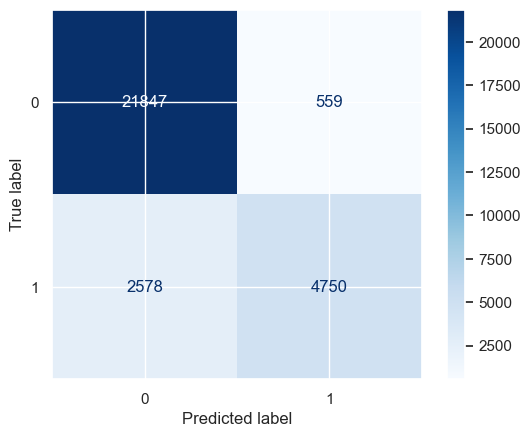

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
 

best_model = results_df[results_df['best_score'] == results_df['best_score'].max()]['grid'].unique()[0].best_estimator_
pred = best_model.predict(X_test)
print(classification_report(pred,y_test))

# คำนวณ confusion matrix
cm = confusion_matrix(y_test, pred)

# สร้างและ plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [43]:
# import joblib
# joblib.dump(results_df[results_df['best_score'] == results_df['best_score'].max()]['grid'].unique()[0], 'grid_search_result.pkl')


# Feature Importance

In [44]:
feature_names = X_resampled.columns
selected_mask  = best_model.named_steps['select'].get_support()
selected_features = feature_names[selected_mask]

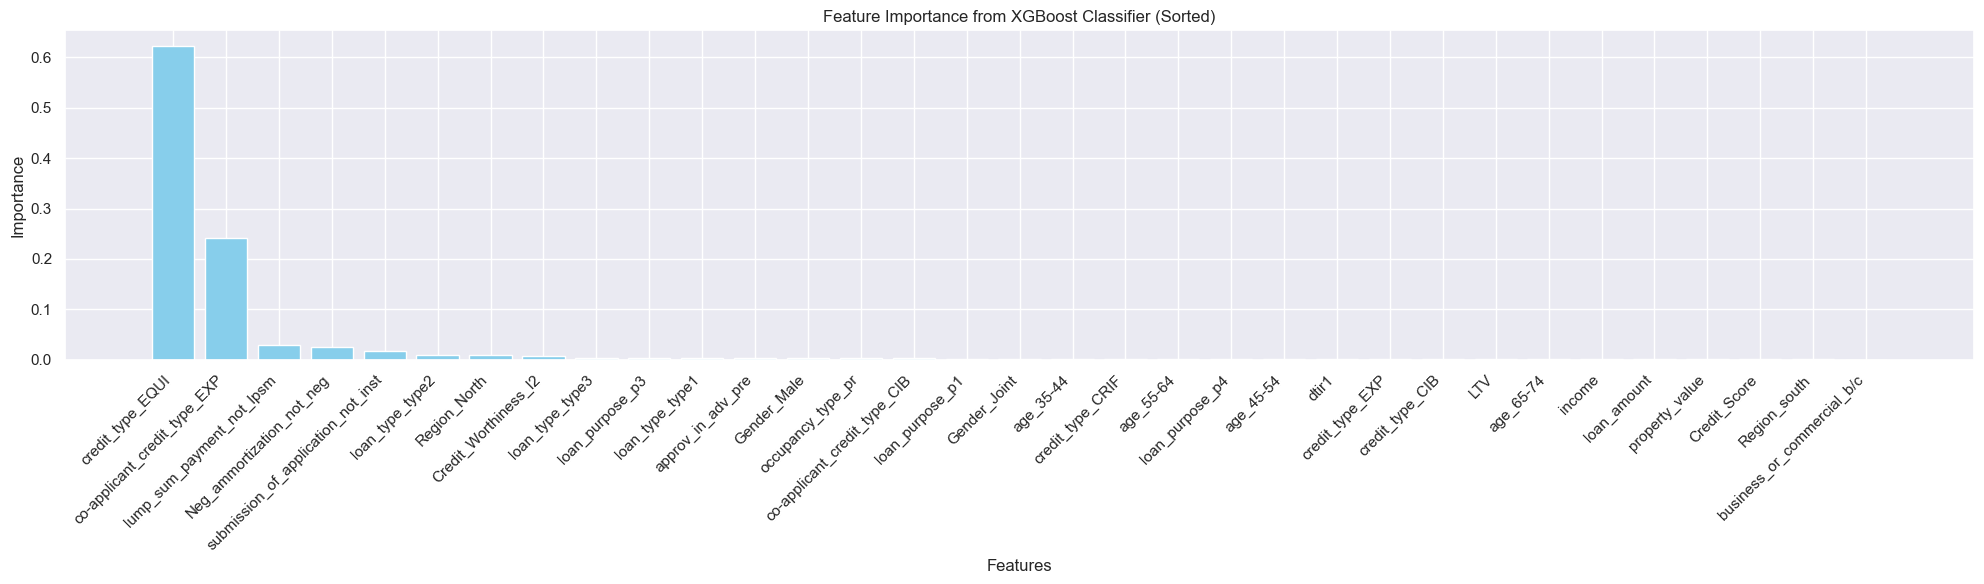

In [45]:
importances = best_model.named_steps['classifier'].feature_importances_

# เรียง index จากค่าความสำคัญจากมากไปน้อย
sorted_idx = np.argsort(importances)[::-1]

# เรียง features และ importances ตามลำดับที่เรียงแล้ว
sorted_features = selected_features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot feature importance
plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from XGBoost Classifier (Sorted)')
plt.tight_layout()
plt.show()

# SHAP Value

In [ ]:
# แปลงข้อมูล X_train ด้วย StandardScaler
X_scaled = best_model.named_steps['scale'].transform(X_resampled)

# เลือกเฉพาะฟีเจอร์ที่ถูกเลือกโดย SelectFromModel
X_selected = X_scaled[:, best_model.named_steps['select'].get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# คำนวณ SHAP values
explainer = shap.Explainer(best_model.named_steps['classifier'])
shap_values = explainer(X_selected_df)

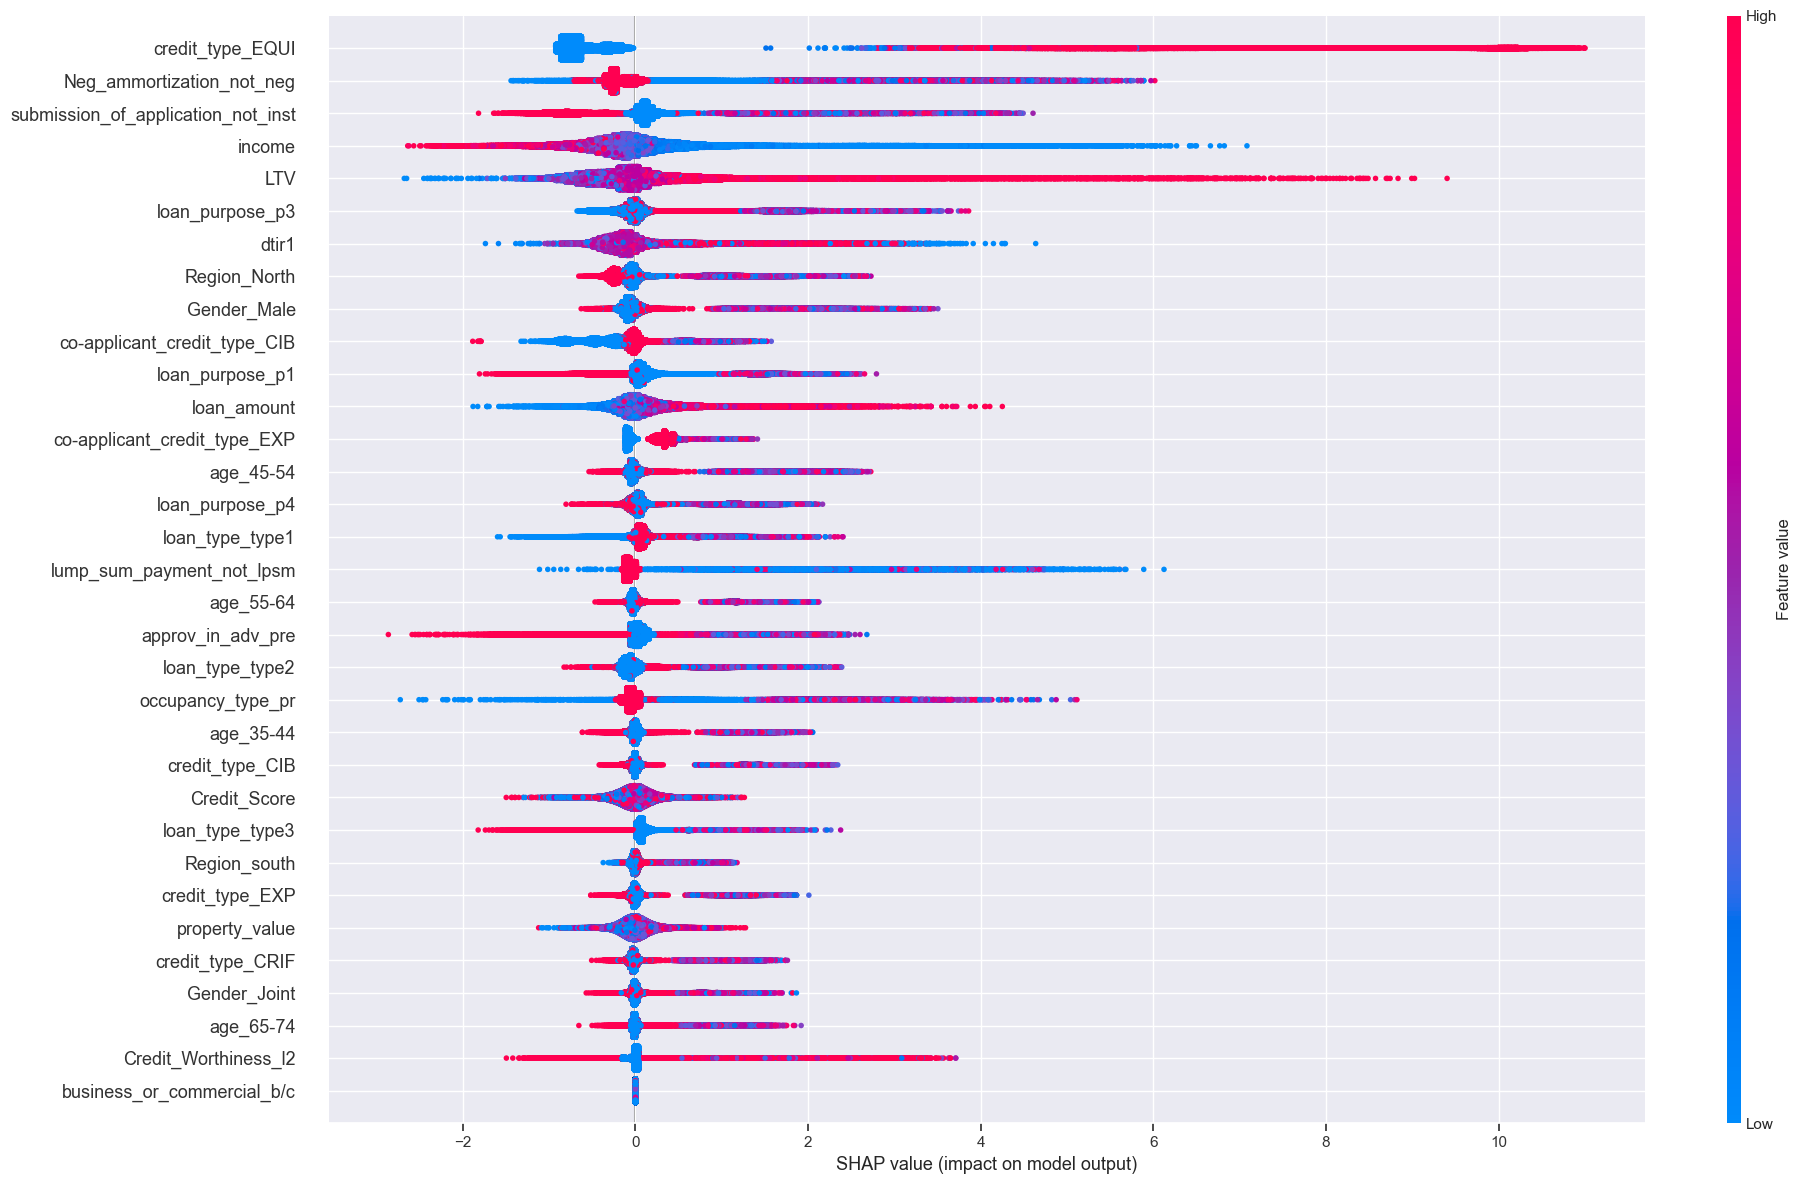

In [88]:
shap.summary_plot(shap_values, X_selected, feature_names=selected_features,plot_size=(20,12),max_display = len(selected_features))

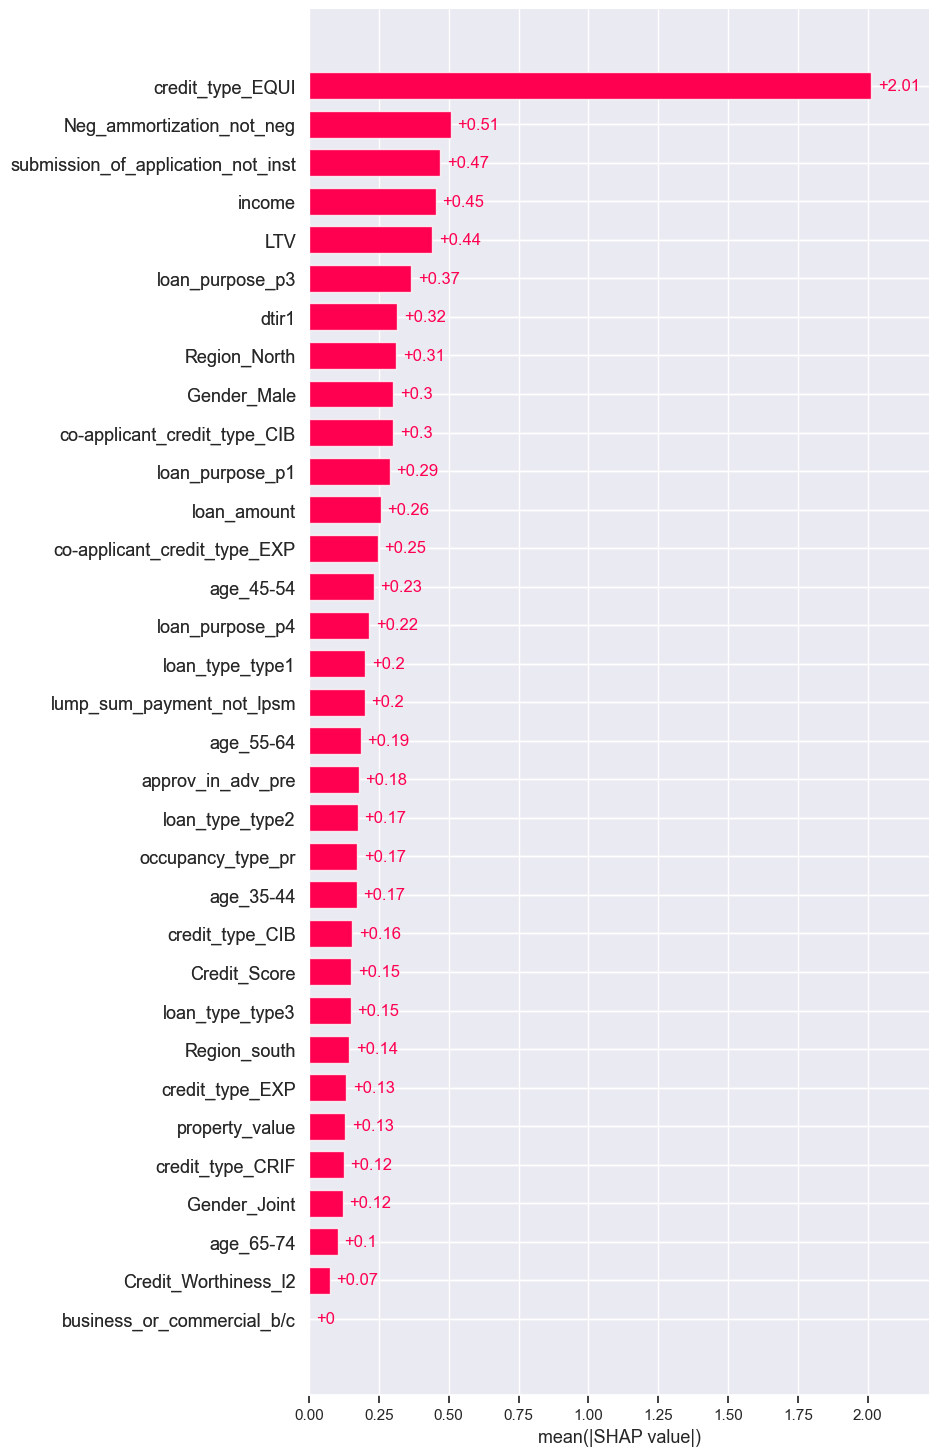

In [ ]:
shap.plots.bar(shap_values, max_display=len(selected_features))

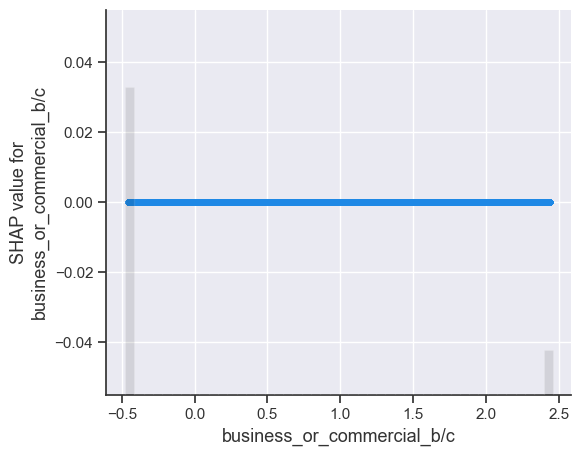

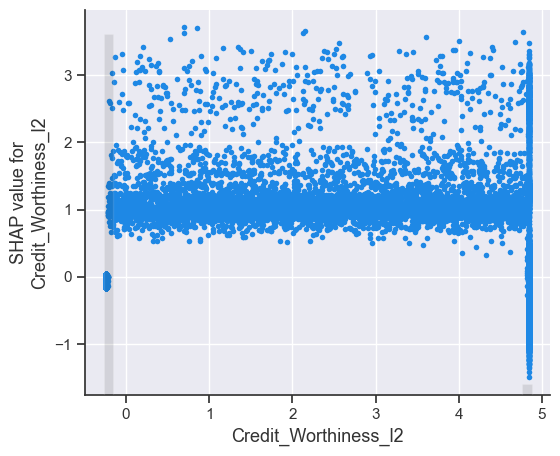

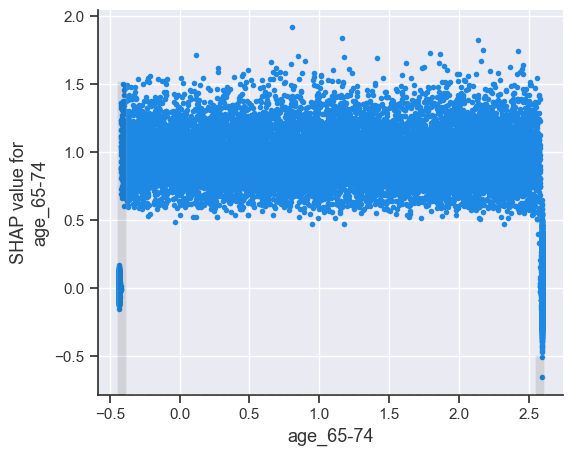

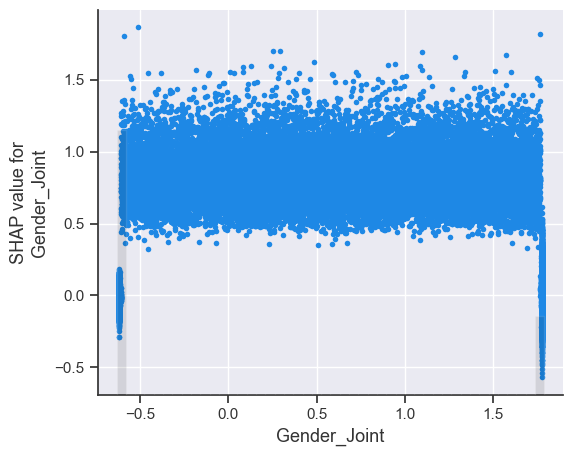

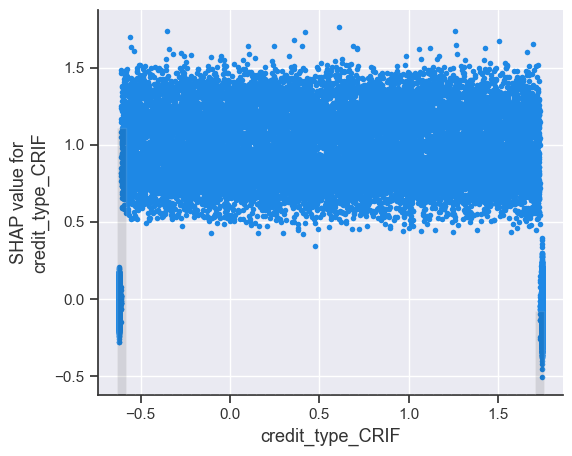

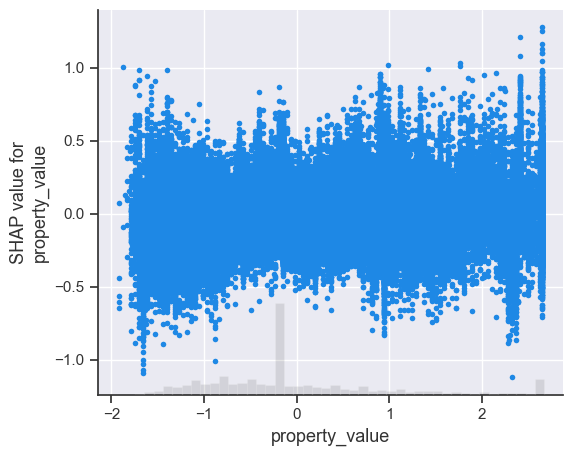

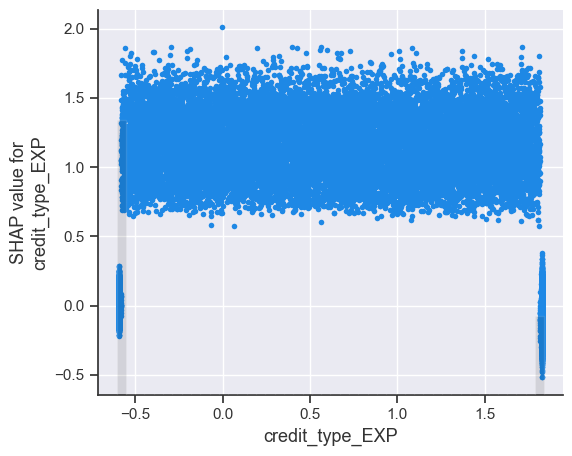

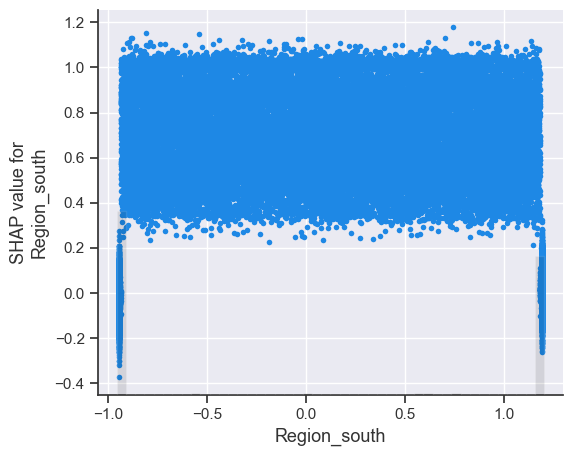

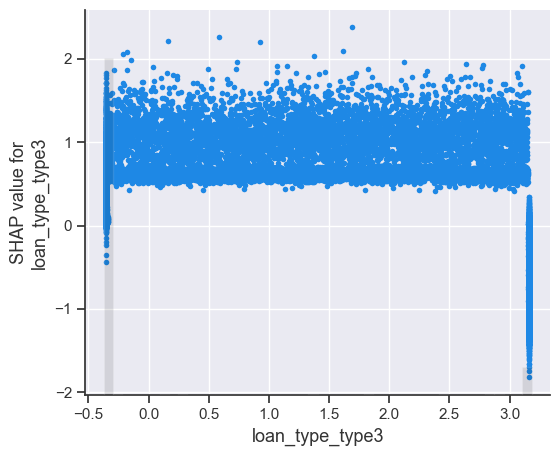

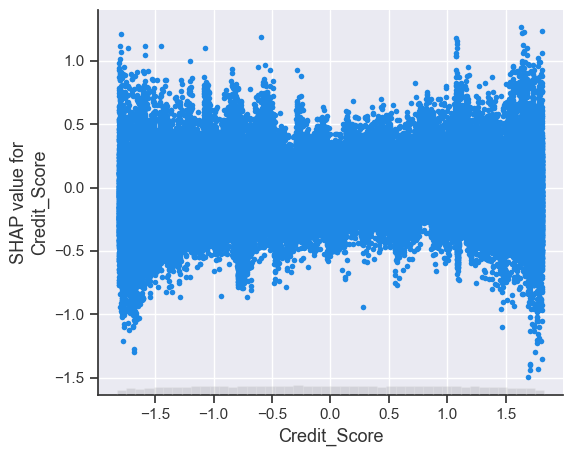

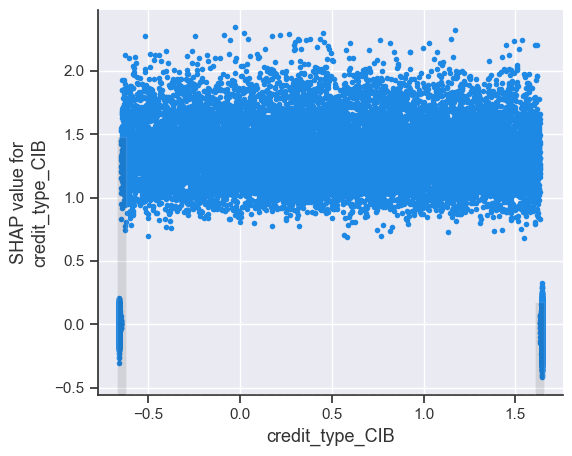

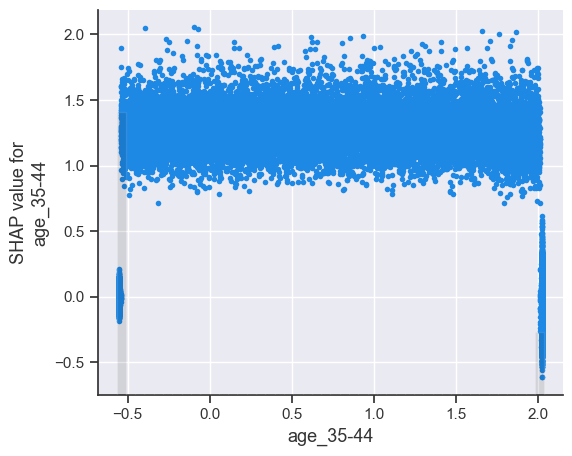

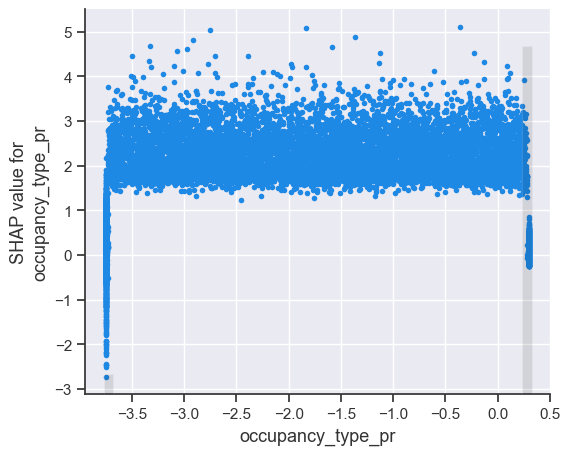

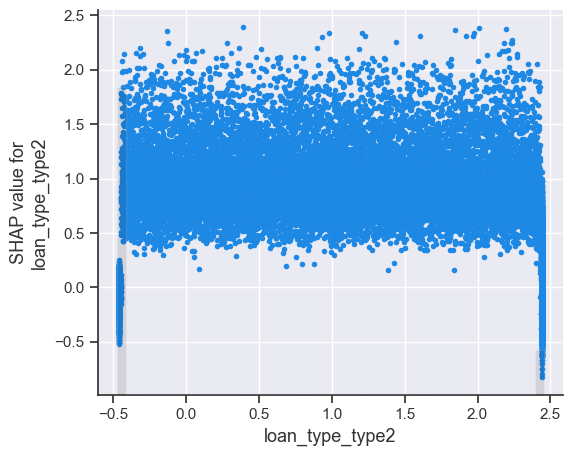

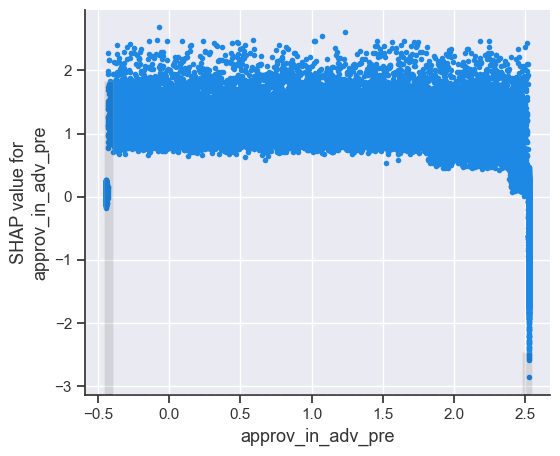

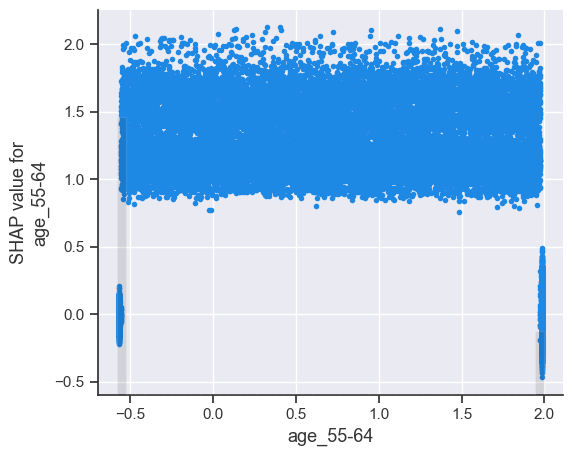

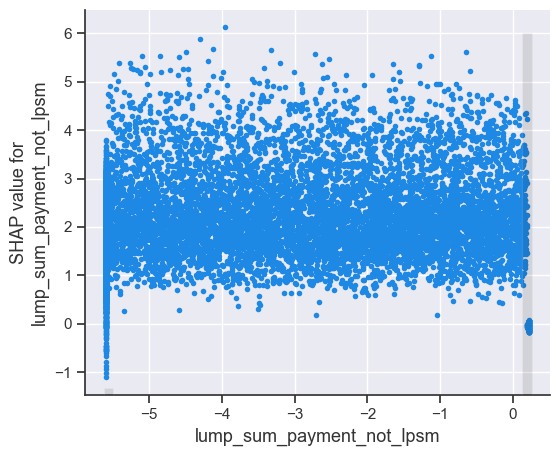

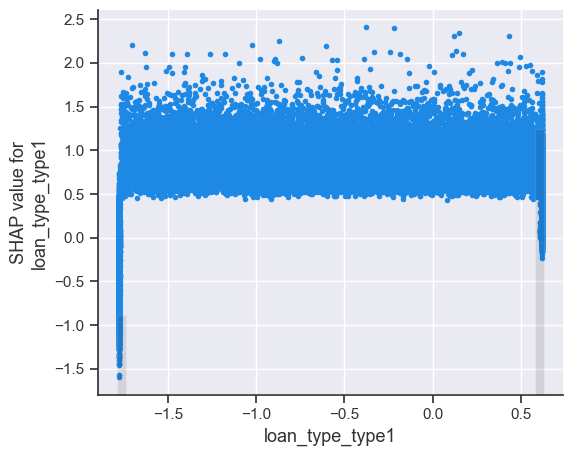

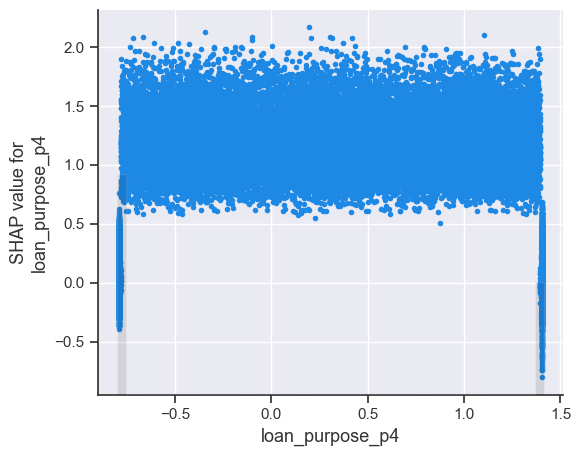

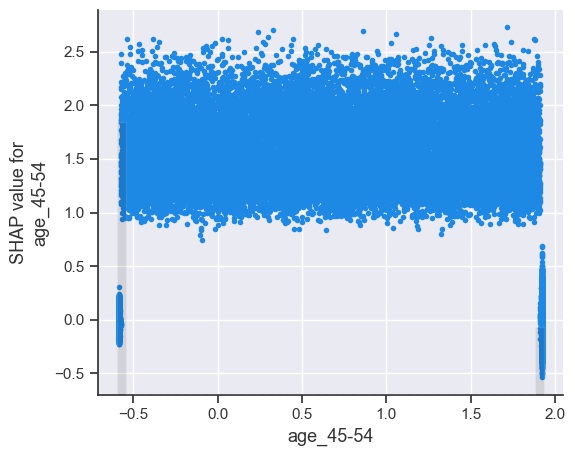

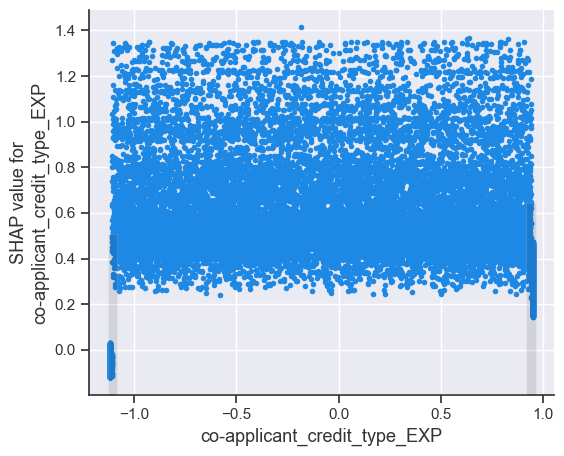

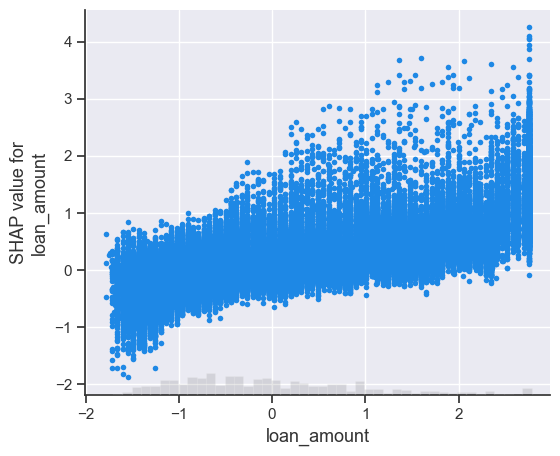

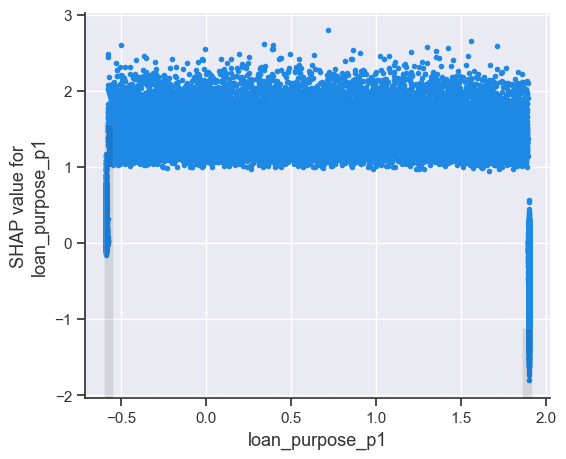

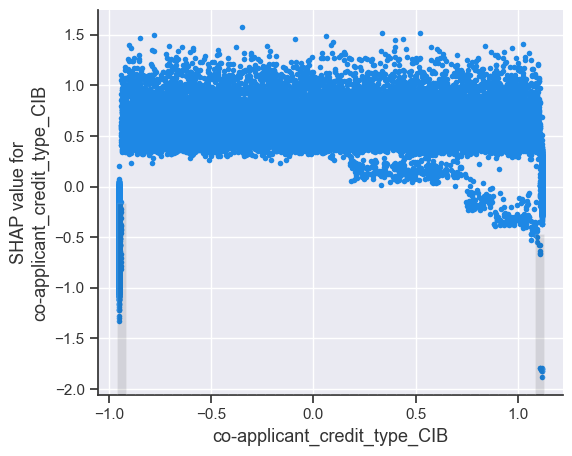

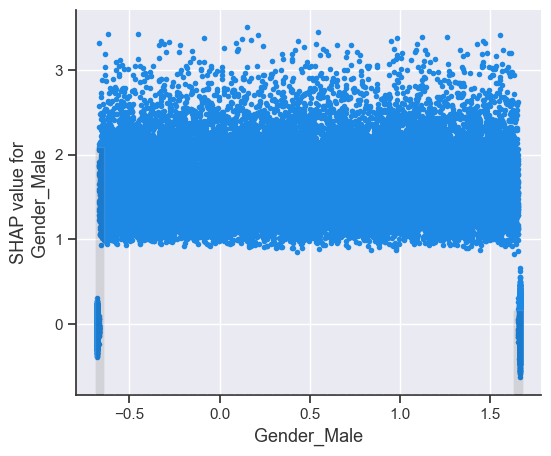

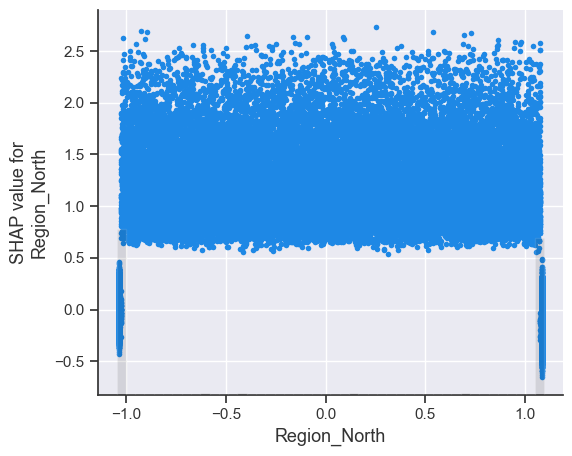

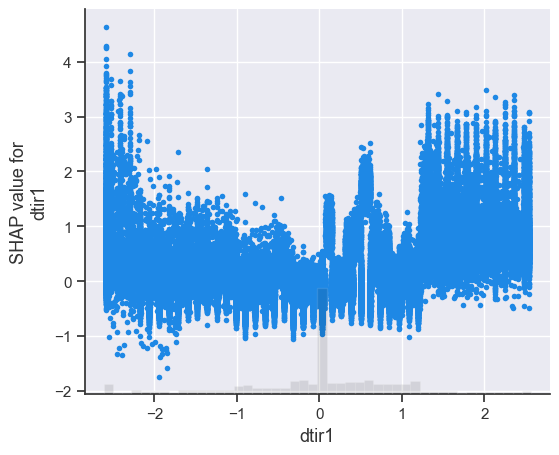

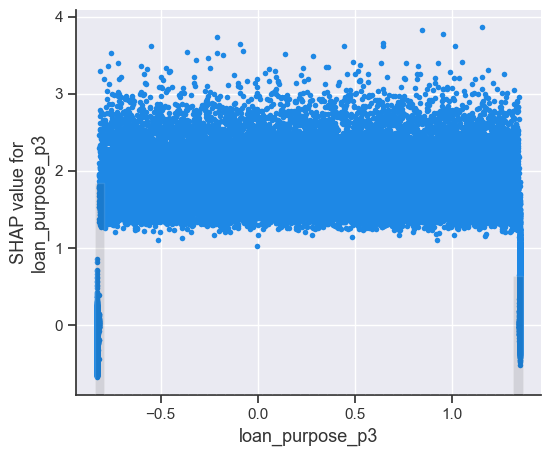

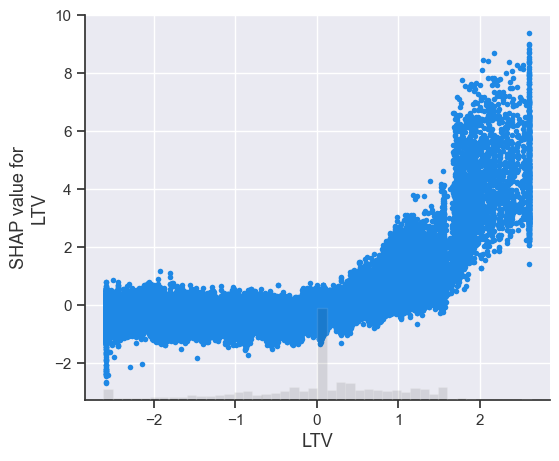

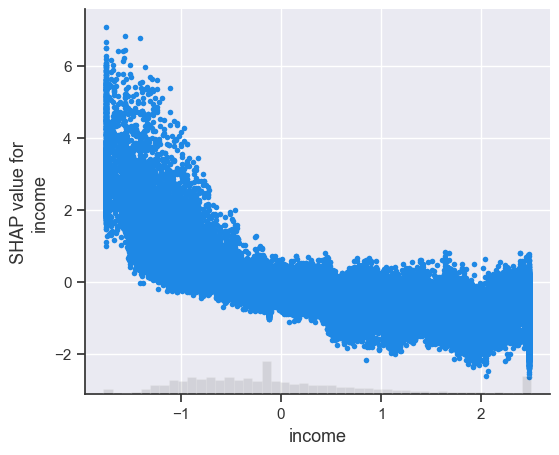

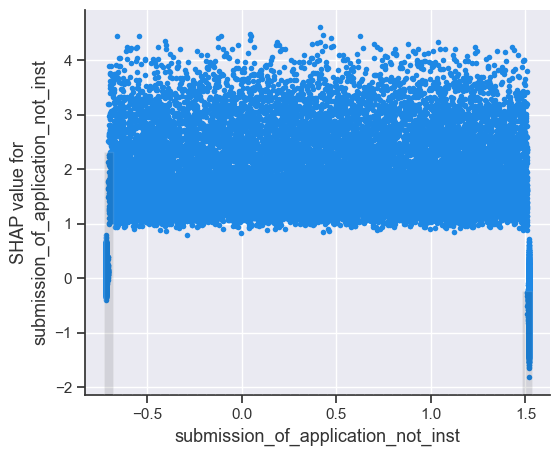

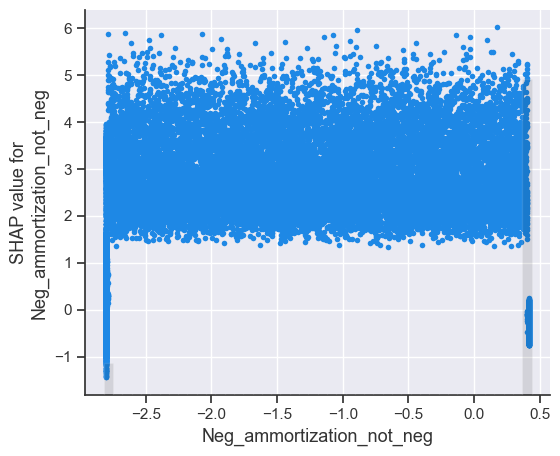

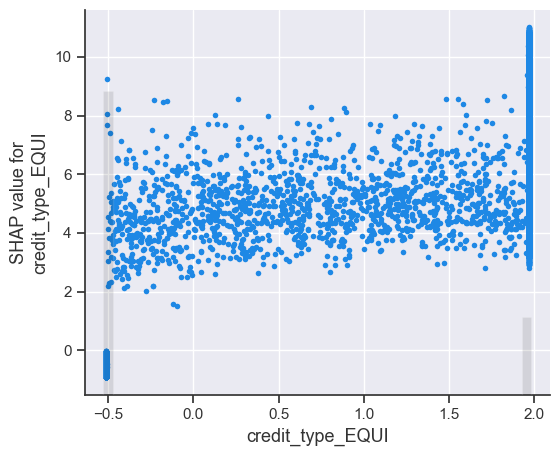

In [91]:
importance_ranking = shap_values.abs.mean(0).values
top_features = X_selected_df.columns[importance_ranking.argsort()]

for feature in top_features:
    shap.plots.scatter(shap_values[:, feature])

# Appendix (Data Understanding)

In [3]:
import math
from model_function import *
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [4]:
def plot_target_correlation_heatmap(df, target_column):
    # เลือกเฉพาะคอลัมน์ที่เป็น numeric
    numeric_df = df.select_dtypes(include=['number'])
    
    # คำนวณ correlation ของ numeric columns กับ target column
    correlation = numeric_df.corr()[[target_column]]
    
    # สร้าง heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation with {target_column}')
    plt.show()

In [5]:
df = pd.read_csv('Loan_Default.csv')
id_column = 'ID'
target = 'Status'
df = df.set_index(id_column)
df = df.drop(['year','Interest_rate_spread'],axis=1)
df = df.dropna(subset=target)
# explore_data(df)
# plot_feature_relationships(df,target)

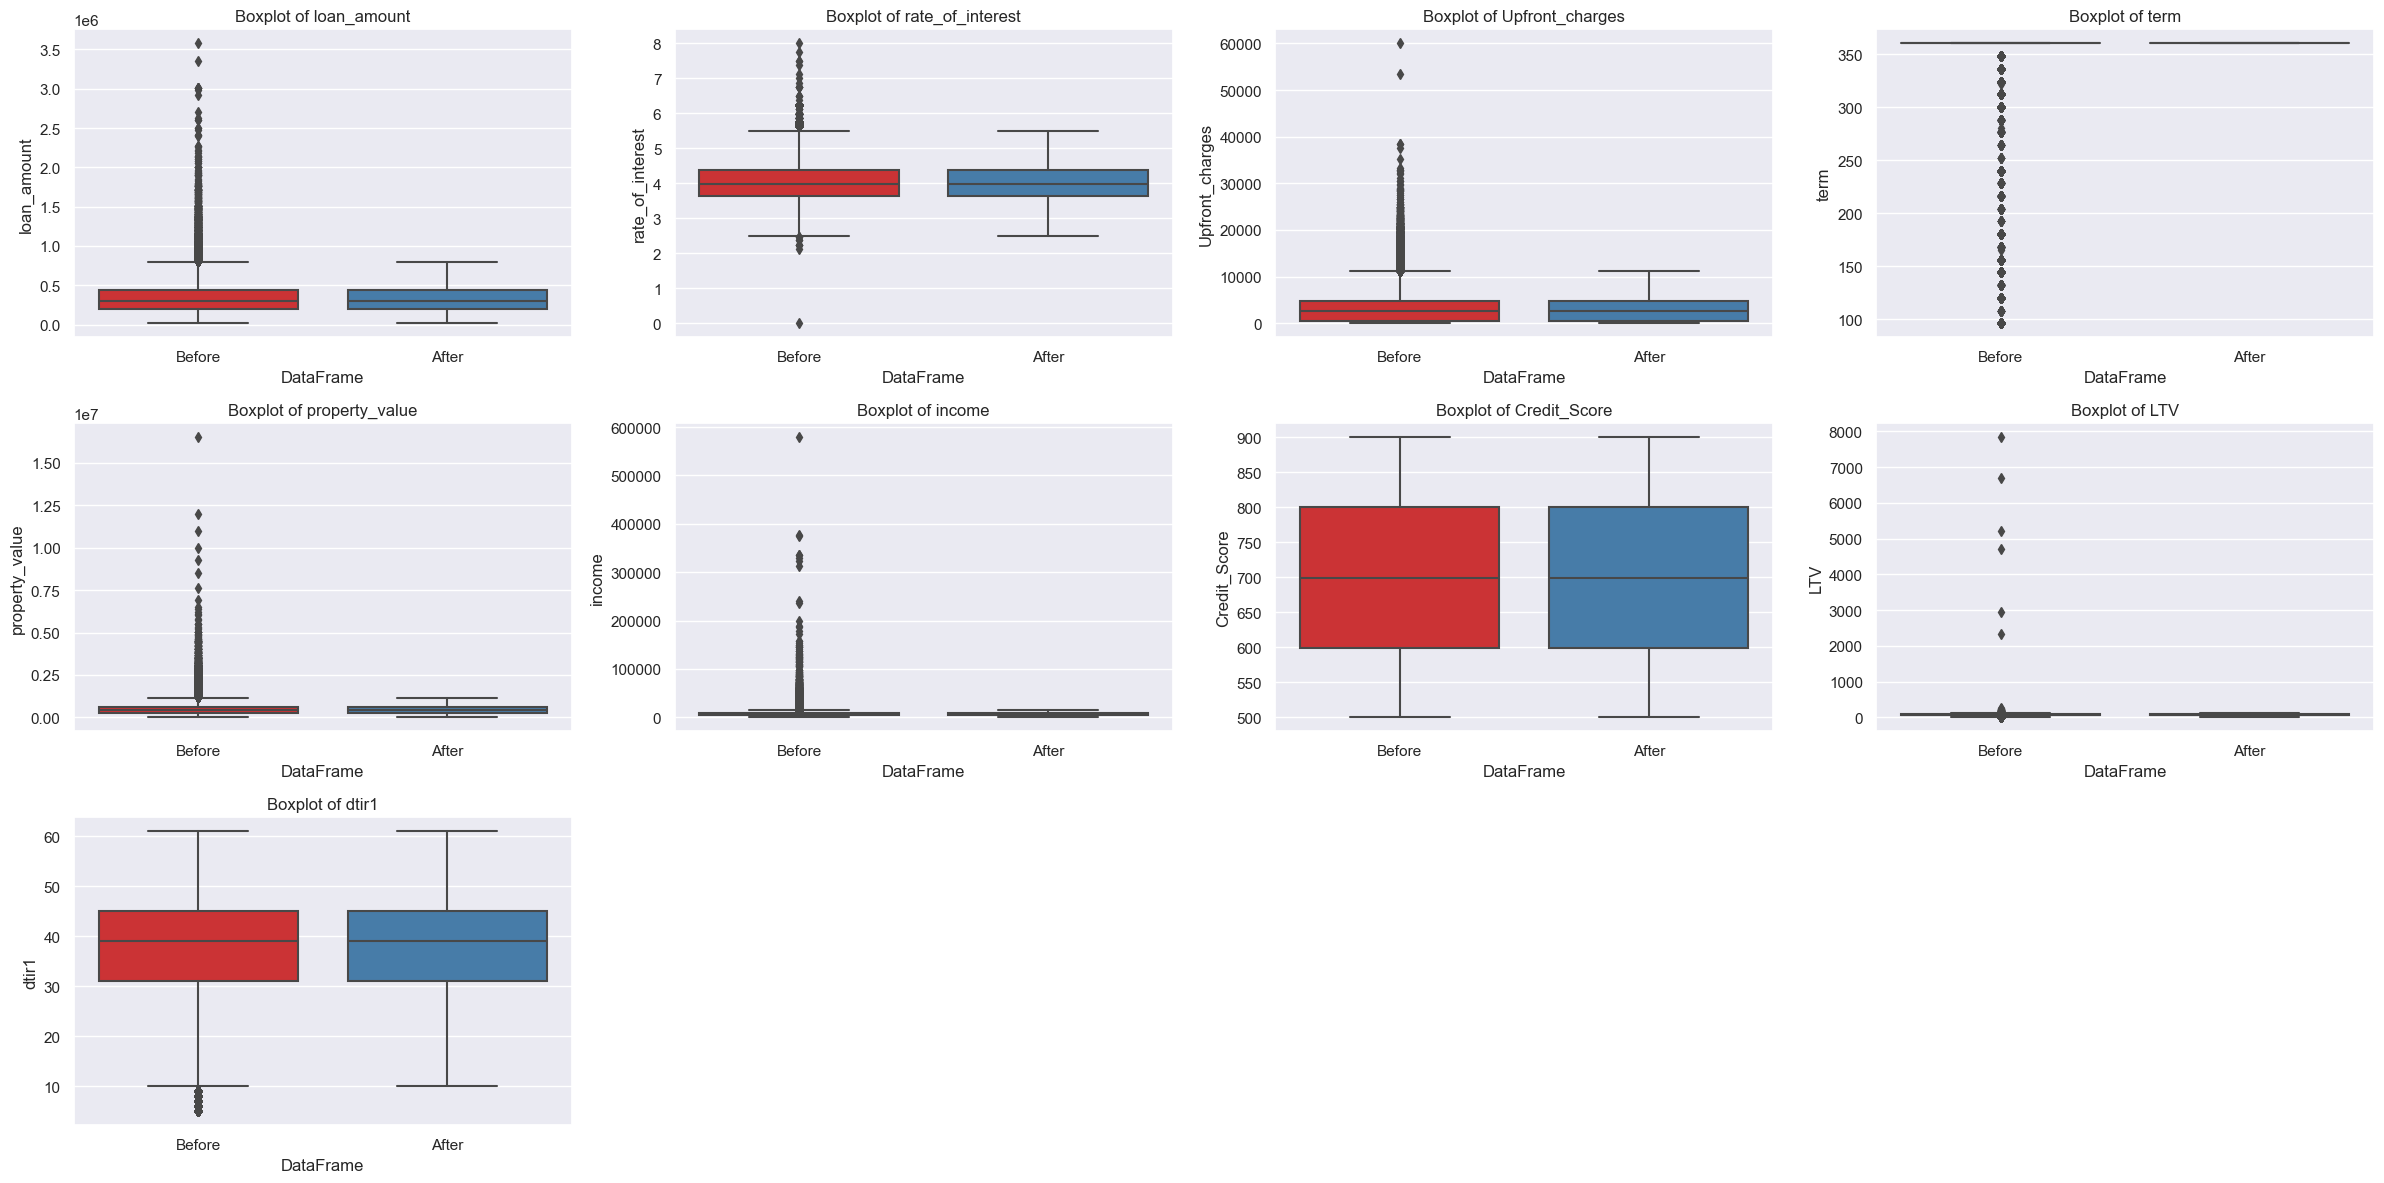

In [6]:
# 2.Cap Outlier
no_outlier = cap_outliers(df, ignore_feature=target, plot=False)
summary = summarize_columns(df, target)
num_cols = summary['numeric']
plot_boxplots_comparison(df,no_outlier,num_cols)

In [7]:
df = cap_outliers(df, ignore_feature=target, plot=False)

In [20]:
def plot_status_comparison(status_series,name):
    """
    สร้าง bar chart เปรียบเทียบจำนวนของ Status 1 และ 0 โดยใช้สีตามที่กำหนด
    และแสดงเปอร์เซ็นต์บนหัวของแท่งใน bar chart
    
    Parameters:
    status_series (pd.Series): Series ที่มีข้อมูลของ Status (1 หรือ 0)
    """
    # กำหนดสี
    hue_colors = {1: '#CB3335', 0: '#477CA8'}
    
    # สร้าง bar chart
    plt.figure(figsize=(4, 4))
    ax = sns.countplot(x=status_series, palette=hue_colors)

    # เปลี่ยนค่าใน x-axis
    ax.set_xticklabels(['Non-Default', 'Default'])

    # คำนวณและแสดงเปอร์เซ็นต์บนหัวแท่ง
    total = len(status_series)
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.text(p.get_x() + p.get_width() / 2, height + 0.05, f'{percentage:.2f}%', 
                ha='center', va='bottom', fontsize=10)
    
    # เพิ่มรายละเอียดในกราฟ
    plt.title(f"Count Plot of Status of {name}")
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

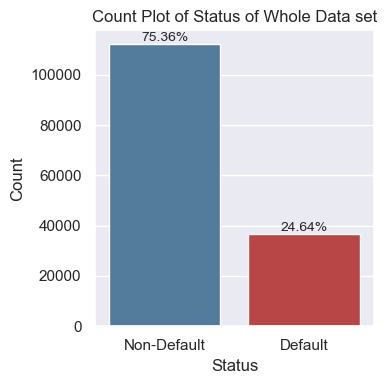

In [21]:
# ตัวอย่างการใช้งาน
plot_status_comparison(df[target],name = 'Whole Data set')

In [11]:
df = pd.read_csv('Loan_Default.csv')
id_column = 'ID'
target = 'Status'
df = df.set_index(id_column)
df = df.drop(['year','Interest_rate_spread'],axis=1)
df = df.dropna(subset=target)

# 1.Fill Missing VAlue
df = handle_missing_values(df,plot_missing = False)

# 2.Cap Outlier
df = cap_outliers(df, ignore_feature=target, plot=False)

# 3.Encode
df_encoded = encode_categorical_features(df, target)

# 4.แบ่ง Train-Test Split โดย Stratify ตาม 'Default'
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(target,axis=1), df_encoded[target], test_size=0.2, stratify=df_encoded[target], random_state=42)

# 5.Smote Train Set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

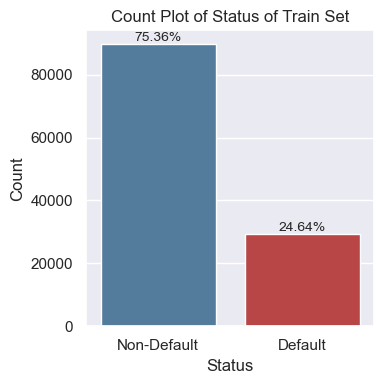

In [22]:
# ตัวอย่างการใช้งาน
plot_status_comparison(y_train,'Train Set')

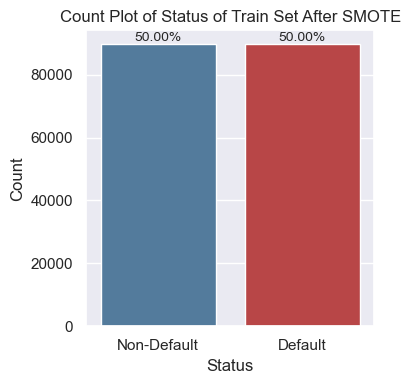

In [23]:
# ตัวอย่างการใช้งาน
plot_status_comparison(y_resampled,'Train Set After SMOTE')

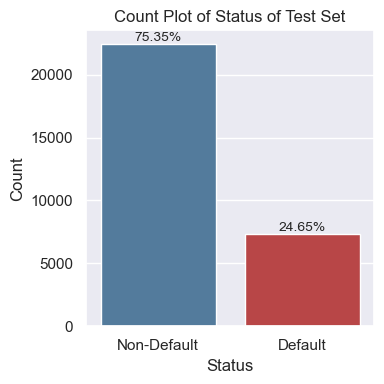

In [24]:
plot_status_comparison(y_test,'Test Set')